In [16]:
from autograd import numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.optimizers import adam, sgd, rmsprop
from autograd import scipy as sp
import pandas as pd
import numpy
import scipy
import matplotlib.pyplot as plt
import statsmodels.api as sm
from normflows import flows
from tqdm import tqdm_notebook as tqdm
import sys
%matplotlib inline

# Variational Inference with Normalizing Flows 
## Original Paper by : Danilo Jimenez Rezende and Shakir Mohamed
## Implemented by : Benjamin Levy and Sujay Thakur

### Motivation
The broad idea of Variational Inference (VI) is to approximate a hard posterior $p$ (does not have an analytical form and we cannot easily sample from it) with a distribution $q$ from a family $Q$ that is easier to sample from. The choice of this $Q$ is one of the core problems in VI. Most applications employ simple families to allow for efficient inference, focusing on mean-field assumptions. This states that our approximate distribution 

$$q(z) = \prod_{i=d}^Dq(z_d)$$

i.e. factorizes completely completely over each dimension. It turns out that this restriction significantly impacts the quality of inferences made using VI, because it cannot model any correlations between dimensions. Hence, no solution of VI will ever be able to resemble the true posterior $p$ if there is any correlation present in it. In contrast, other inferential methods such as MCMC guarantee samples from the true $p$ in the asymptotic limit. We illustrate this shortcoming of mean-field VI with a simple example below.

Given a dataset $\{(x_n, y_n)\}_{n=1}^N$, assume that the outcome $y_n$ can be modeled by the following process:

\begin{aligned}
y_n &= w_1x_n + w_0 + \epsilon,\\
\epsilon &\sim \mathcal{N}(0, 0.5)\\
w_0 &\sim \mathcal{N}(0, 1)\\
w_1 &\sim \mathcal{N}(0, 0.5)
\end{aligned}

Hence, the log posterior $\log p(\textbf{w}|\mathcal{D})$ is given by:

$$\log \left[ \left(\prod_{n=1}^Np(y_n|x_n, \textbf{w})\right) p(\textbf{w}) \right] = -\frac{1}{2}\textbf{w}^T\left( \Sigma_{prior} ^{-1} + \sum_{n=1}^N \frac {\textbf{x}_n \textbf{x}_n^T}{\sigma_{\epsilon}^2} \right)\textbf{w} + \textbf{w}^T \left (\Sigma_{prior} ^{-1} \mu_{prior} + \sum_{n=1}^N \frac {y_n \textbf{x}_n}{\sigma_{\epsilon}^2} \right) + const.$$

Since we know this is a quadratic exponential and is Guassian, comparing with a standard multivariate Gaussian, the posterior is a bivariate Gaussian $\textbf{w} \sim \mathcal{N}(\mu_{post}, \Sigma_{post})$, where

$$\begin{aligned}
    \Sigma_{post} ^{-1} &= \Sigma_{prior} ^{-1} + \sum_{n=1}^N \frac {\textbf{x}_n \textbf{x}_n^T}{\sigma_{\epsilon}^2} \\
    \mu_{post} &= \Sigma_{post} \left (\Sigma_{prior} ^{-1} \mu_{prior} + \sum_{n=1}^N \frac {y_n \textbf{x}_n}{\sigma_{\epsilon}^2} \right)
\end{aligned}
$$

In this particular case, 

$$\Sigma_{post} ^{-1} = \begin{bmatrix}
    1 & 0 \\
    0 & 0.5
  \end{bmatrix}^{-1} + \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N \begin{bmatrix}
    1\\
    x_n
  \end{bmatrix} \begin{bmatrix}
    1 & x_n
  \end{bmatrix} = \begin{bmatrix}
    1+\frac{N}{\sigma_{\epsilon}^2} & \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_n \\
    \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_n & 2+\frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_n^2
  \end{bmatrix}$$
  
whereas the terms inside the brackets for $\mu_{post}$ are
  
$$\Sigma_{prior} ^{-1} \mu_{prior} + \sum_{n=1}^N \frac {y_n \textbf{x}_n}{\sigma_{\epsilon}^2} = 0 + \begin{bmatrix}
    \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N y_n\\
    \frac{1}{\sigma_{\epsilon}^2}\sum_{n=1}^N x_ny_n
  \end{bmatrix}$$
  
We note that this posterior has correlation terms due to the non-zero diagonals in covariance matrix $\Sigma$. Let us now approximate this using mean-field VI.

In [2]:
#Read in the data
df = pd.read_csv('data/HW0_data.csv')
X = df['x'].values.reshape(-1,1)
y = df['y'].values.reshape(-1,1)
X_mat = sm.add_constant(X)

In [3]:
#Construct the derived posterior inverse covariance matrix from above
cov_postinv = np.zeros([2,2])
cov_postinv[0][0] = 1 + len(X)/0.5
cov_postinv[0][1] = X.sum()/0.5
cov_postinv[1][0] = X.sum()/0.5
cov_postinv[1][1] = 2 + (X**2).sum()/0.5
#Get the covariance by taking the inverse
cov_post = np.linalg.inv(cov_postinv)

#Construct the vector within the brackets for mu_post from above
vector = np.zeros([2,1])
vector[0] = y.sum()/0.5
vector[1] = (X*y).sum()/0.5
#Get the posterior mean
mu_post = np.matmul(cov_post, vector)

In [7]:
def black_box_variational_inference(logprob, D, num_samples):
    "Implements http://arxiv.org/abs/1401.0118, and uses the local reparameterization"
    "trick from http://arxiv.org/abs/1506.02557" 
    "code taken from: https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py"
    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std
    
    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        "Provides a stochastic estimate of the variational lower bound."
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound
    
    gradient = grad(variational_objective)
    
    return variational_objective, gradient, unpack_params

def variational_inference(Sigma_W, sigma_y, y_train, x_train, forward, S, max_iteration, step_size, verbose):
    '''implements wrapper for variational inference via bbb for bayesian regression'''
    D = Sigma_W.shape[0]
    Sigma_W_inv = np.linalg.inv(Sigma_W)
    Sigma_W_det = np.linalg.det(Sigma_W)
    variational_dim = D
    
    #define the log prior on the model parameters
    def log_prior(W):
        constant_W = -0.5 * (D * np.log(2 * np.pi) + np.log(Sigma_W_det))
        exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
        log_p_W = constant_W + exponential_W
        return log_p_W

    #define the log likelihood
    def log_lklhd(W):
        S = W.shape[0]
        constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * N
        exponential = -0.5 * sigma_y**-2 * np.sum((y_train - forward(W, x_train))**2, axis=0)
        return constant + exponential

    #define the log joint density
    log_density = lambda w, t: log_lklhd(w) + log_prior(w)

    #build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if verbose:
            if  t % 100 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

    print("Optimizing variational parameters...")
    #initialize variational parameters
#     init_mean = nn.weights.flatten()
#     init_mean = np.ones(D)
    init_mean = np.array([8.81958297,5.2])
    init_log_std = -5 * np.ones(D)
    init_var_params = np.concatenate([init_mean, init_log_std])

    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)

    return variational_params

##polynomial function
def forward(w, x):
    return np.matmul(x, w.T)

In [8]:
D = 2
N = X_mat.shape[0]
sigma_e = 0.5
params = variational_inference(np.array([[1,0],[0,0.5]]),sigma_e, y, X_mat, forward, S=1000, \
                               max_iteration=1000, step_size=1e-1, verbose=True)

Optimizing variational parameters...
Iteration 0 lower bound -30539.466056153142; gradient mag: 152.62214679327647
Iteration 100 lower bound -30536.363573139875; gradient mag: 4.263828645164401
Iteration 200 lower bound -30536.41529699454; gradient mag: 5.2189788551913905
Iteration 300 lower bound -30536.399523534914; gradient mag: 4.536858396887439
Iteration 400 lower bound -30536.400756914736; gradient mag: 12.99753436814084
Iteration 500 lower bound -30536.465640433682; gradient mag: 12.43011565086504
Iteration 600 lower bound -30536.41793852928; gradient mag: 25.94459523568
Iteration 700 lower bound -30536.39405035595; gradient mag: 10.57352972331591
Iteration 800 lower bound -30536.385576378372; gradient mag: 3.887746753029703
Iteration 900 lower bound -30536.468270997004; gradient mag: 1.1049825733521936


Let us plot the PDF of $p$ and the learned $q$.

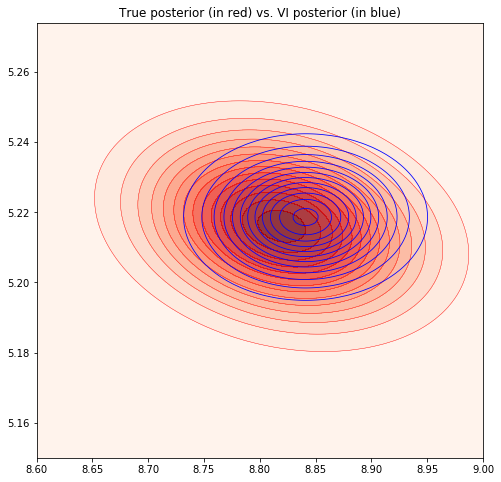

In [10]:
mu_VI = params[:D]
cov_VI = np.diag(np.exp(params[D:])**2)

x, y = numpy.mgrid[8.6:9:.001, 5.15:5.275:.001]
pos = numpy.dstack((x, y))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

z = scipy.stats.multivariate_normal(mu_post.flatten(), cov_post).pdf(pos)
z_VI = scipy.stats.multivariate_normal(mu_VI, cov_VI).pdf(pos)

ax.contourf(x, y, z, levels=14, cmap='Reds', alpha=0.8)
ax.contour(x, y, z, levels=14, linewidths=0.4, colors='red')

ax.contour(x, y, z_VI, levels=14, linewidths=0.8, colors='blue')
plt.title('True posterior (in red) vs. VI posterior (in blue)')

plt.show()

As expected, the true posterior $p$ has a slope due to the non-zero diagonals, something which our mean-field assumed $q$ could never capture. Additionally, there are two commonly experienced problems (Turner & Sahani, 2011):

- Under-estimation of the variance of the posterior. This is observed in the above plot where our $q$ is more concentrated.
- Biases in the MAP solution of parameters. This is observed in the above plot where our learned $\mu$ for $q$ does not coincide perfectly with the true $\mu$ for $p$.

These issues mean that the subsequent decisions we make using our VI solution could be biased and have incorrect uncertainty estimates. In fields such as medical operations, these could have dire consequences.

### Alternatives

There are a number of proposals for rich posterior approximations that have been explored, but there are some limitations :

- Structured mean-field : Instead of assuming fully factorized posteriors, this assumes that the distribution factorizes into a product of tractable distributions, such as trees or chains (Shukla, Shimazaki, & Ganguly, 2019). While this allows for the modeling of some correlations, the subsequent optimization becomes too complex for any realistic applications.
- Mixture model : This specifies the approximate posterior as a mixture model, and hence captures multi-modality well (Jordan et al., 1999). However, this limits the potential scalability of VI since it requires evaluation of the log-likelihood and its gradients for each mixture component per parameter update, which is typically computationally expensive.

### Normalizing Flows

A normalizing flow describes the transformation of a probability density through a series of invertible mappings, making the initial simple density 'flow' through the mappings and result in a more complex distribution (Tabak & Turner, 2013). These mappings can be shown to preserve the PDF normalization property : 

$$\int_\mathbf{z}q_k(\mathbf{z}_k)d\mathbf{z}_k = 1$$

at each stage $k$ of the flow, resulting in a valid density at the end.

We will consider the simple case of Planar flows, which introduces enough complexity in the approximate posterior $q$ for many applications. This uses an invertible and smooth mapping $f:\mathbb{R}^d \rightarrow \mathbb{R}^d$. If we use this to transform a random variable $\mathbf{z} \sim q(\mathbf{z})$, the resulting $\mathbf{z}^\prime = f(\mathbf{z})$ can be shown to be distributed as : 

$$q(\mathbf{z}^\prime) = q(\mathbf{z})\left|\det\frac{\partial f^{-1}}{\partial \mathbf{z}^\prime}\right| = q(\mathbf{z})\left|\det\frac{\partial f}{\partial \mathbf{z}^\prime}\right|^{-1}$$

Now, imagine applying this process multiple times to construct arbitrarily complex distributions. After $K$ such transformations on the initial $\mathbf{z}_0$, using the above equation, the resulting random variable 

$$\mathbf{z}_K = f_K\circ\cdots\circ f_1(\mathbf{z_0})$$

has log density

$$\log q_K(\mathbf{z}_K) = \log q_0(\mathbf{z}_0) - \sum_{k=1}^K \log\left|\det\frac{\partial f_k}{\partial \mathbf{z}_{k-1}}\right|$$

This path formed by the distributions $q_1,\cdots,q_K$ is called a <em>normalizing flow</em>. Using the law of the unconscious statistician (Blitzstein & Hwang, 2014), we are able to compute expectations using the transformed density $q_k$ without explicity knowing it : 

$$\mathbb{E}_{q_k}\left[h(\mathbf{z})\right] = \mathbb{E}_{q_0}\left[h\left(f_k\circ f_{k-1}\circ\cdots\circ f_1(\mathbf{z}_0)\right)\right]$$

Using this equation is one of the major innovations for using normalizing flows for VI, since we will need to eventually compute expectations under later flow distributions $q_k, k\in\{1,\cdots K\}$. However, since it is not always possible to sample $\mathbf{z}_k \sim q_k(\mathbf{z}_k)$ if $q_k$ becomes complex enough, this equation allows us to compute such expectations using $\mathbf{z}_0 \sim q_0$ where $q_0$ would be the simple starting distribution we select, e.g. an isotropic Gaussian.

We can think of these Planar flows as a sequence of expansions and contractions on the initial density $q_0$. To visualize this process and understand how the different parameters affect the flows, we created a applet that can be accessed via ''''''. Go ahead and give it a try!

Planar flows can be expressed as : 

$$f(\mathbf{z}) = \mathbf{z} + \mathbf{u}h(\mathbf{w}^\text{T}\mathbf{z} + b)$$

where the parameters $\lambda = \{\mathbf{w}\in\mathbb{R}^D, \mathbf{u}\in\mathbb{R}^D, b\in\mathbb{R}\}$ and $h$ is a smooth non-linearity that is chosen to be $tanh$ for this flow. Note that we can write the derivative of the $h(\mathbf{w}^\text{T}\mathbf{z} + b)$ term using chain rule as :

$$\psi(\mathbf{z}) = h^\prime(\mathbf{w}^\text{T}\mathbf{z} + b)\mathbf{w}$$

Hence using the matrix determinant lemma,

$$\left|\det\frac{\partial f}{\partial \mathbf{Z}}\right| = \left|\det\left(\mathbf{I} + \mathbf{u}\psi(\mathbf{z})^\text{T}\right)\right| = \left|1 + \mathbf{u}^\text{T}\psi(\mathbf{z})\right|$$


The log density from above can thus be expressed as 

$$\log q_K(\mathbf{z}_K) = \log q_0(\mathbf{z}_0) - \sum_{k=1}^K \log\left|1 + \mathbf{u}_k^\text{T}\psi_k(\mathbf{z}_{k-1})\right|$$

which only requires an analytical distribution expression for the simple $q_0$.

### VI with Normalizing Flows 

This paper proposes a technique to implement VI using Normalizing Flows. The main ideas from the authors are : 
 - Specify the approximate posterior using normalizing flows that allows for construction of complex distributions by transforming a density through a series of invertible mappings. This provides a tighter, modified evidence lower bound (ELBO) with additional terms that have linear time complexity. This is in contrast with the alternative methods above which require more complex optimizations.
 - It can be shown that using VI with normalizing flows specifies a class of $q$ distributions that provide asymptotic guarantees, as opposed to naive mean-field VI.
 - This method is shown to systematically outperform other competing approaches for posterior approximation.
 
We will now provide deeper explanations of the above ideas. As an overview, we consider the general Variational Autoencoder (VAE) structure. In VAEs, we assume that the data is generated by the following process (Pan, 2019): 

<table>
    <tr>
        <td>
            <img src="./fig/VAE_graphical.png" style="height:200px;" align="center">
        </td>
        <td>
            \begin{align}
            z_n &\sim p_\theta(z), \; \mathbf{(prior)}\\
            x_n &\sim p_\theta(x_n|z_n), \; \mathbf{(likelihood)}
            \end{align}
        </td>
    </tr>
</table>

Hence we need to : 

- Learn $f_\theta$, ***the generative network***, that will learn the mapping from latent variable $z_n$ to observed data $x_n$. Hopefully, we can learn to mimic the empirical distribution of observed data well.

- Learn $g_\phi$, ***the inference network***, that will learn the mapping from observed data $x_n$ to latent variable $z_n$. Hopefully, we can learn to infer the best approximation to the posterior $p(z_n|x_n)$ given an observation $x_n$.

These are summarized in the image below : 


<img src="./fig/trial.jpg" style="height:200px" align="center"/>


As shown, the normalizing flows are used to provide complexity in the latent $\mathbf{z}_n$ that are used in the overall VAE. As per the standard variational formulation (Jordan et al., 1999), the marginal observed data likelihood can be bound as : 

$$\begin{aligned}
\log p_\theta (\mathbf{x}) &= \log \int p_\theta (\mathbf{x}|\mathbf{z})p(\mathbf{z})d\mathbf{z}\\
&= \log \int \frac{q_\phi(\mathbf{z}|\mathbf{x})}{q_\phi(\mathbf{z}|\mathbf{x})}p_\theta (\mathbf{x}|\mathbf{z})p(\mathbf{z})d\mathbf{z}\\
&\geq -\mathbb{D}_{\text{KL}}\left[q_\phi(\mathbf{z}|\mathbf{x}) \middle\| p(\mathbf{z})\right] + \mathbb{E}_{q_\phi(z|x)}\left[\log p_\theta (\mathbf{x}|\mathbf{z})\right]\\
&= \mathbb{E}_{q_\phi(z|x)}\left[\log p(\mathbf{x}, \mathbf{z}) - \log q_\phi(\mathbf{z}|\mathbf{x})\right]\\
&= -\mathcal{F}(\mathbf{x})
\end{aligned}$$

where we used Jensen's to obtain the inequality. We hence have to minimize this free energy $\mathcal{F}(\mathbf{x})$. We now integrate this with our normalizing flows formulation. As per the diagram above, we parameterize the overall VAE approximate posterior with a flow of length $K$ :

$$q_\phi(\mathbf{z}|\mathbf{x}) := q_K(\mathbf{z}_K)$$

The free energy now becomes : 

$$\begin{aligned}
\mathcal{F}(\mathbf{x}) &= \mathbb{E}_{q_\phi(z|x)}\left[\log q_\phi(\mathbf{z}|\mathbf{x}) - \log p(\mathbf{x}, \mathbf{z})\right] \\
&= \mathbb{E}_{q_0(z_0)}\left[\log q_K(\mathbf{z}_K) - \log p(\mathbf{x}, \mathbf{z}_K)\right] \\
&= \mathbb{E}_{q_0(z_0)}\left[\log q_0(\mathbf{z}_0)\right] - \mathbb{E}_{q_0(z_0)}\left[\log p(\mathbf{x}, \mathbf{z}_K)\right]-\mathbb{E}_{q_0(z_0)}\left[\sum_{k=1}^K \log\left|1 + \mathbf{u}_k^\text{T}\psi_k(\mathbf{z}_{k-1})\right|\right]
\end{aligned}$$

where we used the normalizing flow log density derived above. We now have an objective function to minimize that only needs an analytical expression for the chosen simple distribution $q_0$, an analytical expression for the joint likelihood $p$ that depends on our model and the various flow parameters $\lambda$ that we want to learn. The generative network parameters $\theta$ are a part of the likelihood $p$ while the inference network parameters $\phi$ are the flow parameters $\lambda$ which is a part of the final summation term. We can also opt to learn the optimal parameters of the initial distribution $q_0$, which would be a part of the first term. Hence, optimizing $\mathcal{F}$ should allow us to learn the optimal $\theta, \phi$ as needed in VAEs. All the expectations can be computed using Monte Carlo estimation with $\mathbf{z}_0 \sim q_0$, something that we can easily sample. We are thus able to minimize the objective using any optimization package.

### Results

We first consider the simpler case where we have no observed data, and just wish to approximate an arbitrarily complex posterior that we can analytically define. The paper considers the following four potentials for bivariate $\mathbf{z}$ : 

$$\begin{aligned}
U_1(\mathbf{z}) &= \frac{1}{2}\left(\frac{\left\lVert\mathbf{z}\right\rVert -2}{0.4}\right)^2 - \log\left[e^{-\frac{1}{2}\left(\frac{\mathbf{Z}_1-2}{0.6}\right)^2} + e^{-\frac{1}{2}\left(\frac{\mathbf{Z}_1+2}{0.6}\right)^2}\right]\\
U_2(\mathbf{z}) &= \frac{1}{2}\left(\frac{\mathbf{z}_2 -w_1(\mathbf{z})}{0.4}\right)^2\\
U_3(\mathbf{z}) &= - \log\left[e^{-\frac{1}{2}\left(\frac{\mathbf{Z}_2 -w_1(\mathbf{Z})}{0.35}\right)^2} + e^{-\frac{1}{2}\left(\frac{\mathbf{Z}_2 -w_1(\mathbf{Z}) + w_2(\mathbf{Z})}{0.35}\right)^2}\right]\\
U_4(\mathbf{z}) &= - \log\left[e^{-\frac{1}{2}\left(\frac{\mathbf{Z}_2 -w_1(\mathbf{Z})}{0.4}\right)^2} + e^{-\frac{1}{2}\left(\frac{\mathbf{Z}_2 -w_1(\mathbf{Z}) + w_3(\mathbf{Z})}{0.35}\right)^2}\right]\\
\end{aligned}$$

where

$$\begin{aligned}
w_1(\mathbf{z}) &= \sin\left(\frac{2\pi\mathbf{z}_1}{4}\right)\\
w_2(\mathbf{z}) &= 3e^{-\frac{1}{2}\left(\frac{\mathbf{Z}_1-1}{0.6}\right)^2}\\
w_3(\mathbf{z}) &= 3\sigma\left(\frac{\mathbf{z}_1-1}{0.3}\right)\\
\sigma(x) &= \frac{1}{1+e^{-x}}
\end{aligned}$$

and where the distribution $p(\mathbf{z}) \propto e^{-U(\mathbf{z})}$. We visualise these below.

In [17]:
sigmoid = lambda x: 1/(1+np.exp(-x))
w1 = lambda x: np.sin(2 * np.pi * x/4)
w2 = lambda x: 3*np.exp(-0.5*((x-1)/0.6)**2)
w3 = lambda x: 3*sigmoid((x-1)/0.3)

def trial1(z):
    if len(z.shape)>1:
        z1, z2 = z[:, 0], z[:, 1]
    else:
        z1, z2 = z[0], z[1]
    norm = np.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = np.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = np.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - np.log(exp1 + exp2)
    return np.exp(-u)        

def p1(z):
    '''Apply posterior p_1 to bivariate z.'''
    if len(z.shape)>1:
        z1, z2 = z[:, 0], z[:, 1]
        first = (np.linalg.norm(z, 2, 1) - 2)/0.4
        exp1 = np.exp(-0.5*((z1 - 2)/0.6)**2)
        exp2 = np.exp(-0.5*((z1 + 2)/0.6)**2)
        u = 0.5*first**2 - np.log(exp1 + exp2)
        return np.exp(-u)
    else:
        first = (np.linalg.norm(z)-2)/0.4
        second = np.exp(-0.5*((z[0] - 2)/0.6)**2)
        third = np.exp(-0.5*((z[0] + 2)/0.6)**2)
        return np.exp(-0.5*first**2 + np.log(second+third))

def p2(z):
    '''Apply posterior p_2 to bivariate z.'''
    if len(z.shape)>1:
        z1, z2 = z[:, 0], z[:, 1]
        u = 0.5 * ((z2 - w1(z1))/0.4) ** 2
        dummy = np.ones(u.shape) * 1e7
        u = np.where(np.abs(z1) <= 4, u, dummy)
        return np.exp(-u)
    else:
        first = (z[1] - w1(z[0]))/0.4
        return np.exp(-0.5*first**2)

def p3(z):
    '''Apply posterior p_3 to bivariate z.'''
    if len(z.shape)>1:
        z1, z2 = z[:, 0], z[:, 1]
        exp1 = np.exp(-0.5*((z2 - w1(z1))/0.35)**2)
        exp2 = np.exp(-0.5*((z2 - w1(z1) + w2(z1))/0.35)**2)
        u = - np.log(exp1 + exp2)
        return np.exp(-u)
        
    else:
        first = np.exp(-0.5*((z[1] - w1(z[0]))/0.35)**2)
        second = np.exp(-0.5*((z[1] - w1(z[0]) + w2(z[0]))/0.35)**2)
        return first+second

def p4(z):
    '''Apply posterior p_4 to bivariate z.'''
    if len(z.shape)>1:
        z1, z2 = z[:, 0], z[:, 1]
        exp1 = np.exp(-0.5*((z2 - w1(z1))/0.4)**2)
        exp2 = np.exp(-0.5*((z2 - w1(z1) + w3(z1))/0.35)**2)
        u = - np.log(exp1 + exp2)
        return np.exp(-u)
    else:
        first = np.exp(-0.5*((z[1] - w1(z[0]))/0.4)**2)
        second = np.exp(-0.5*((z[1] - w1(z[0]) + w3(z[0]))/0.35)**2)
        return first+second

In [6]:
ndim = 2
mu0 = np.zeros(ndim)
Sigma0 = np.eye(ndim)
N = 1000

samples = np.random.multivariate_normal(mu0, Sigma0, size=N)

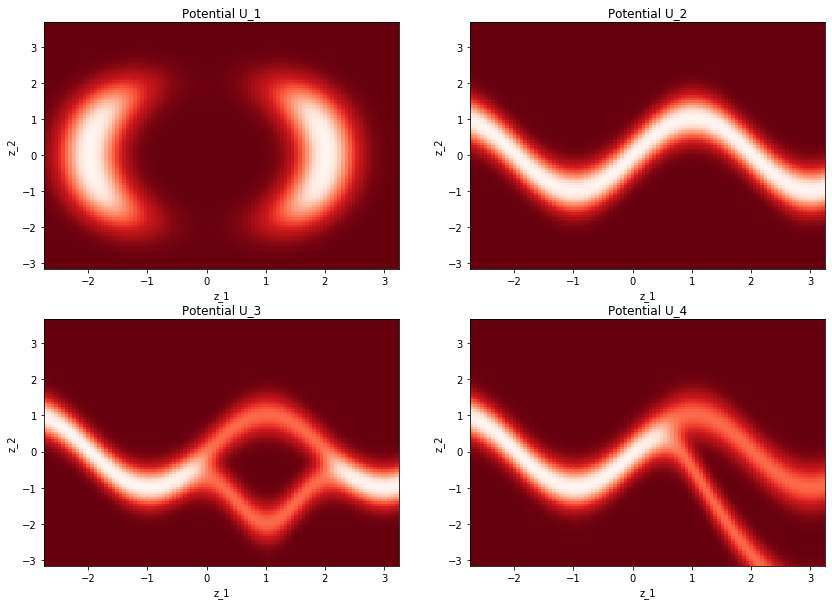

In [9]:
fig,ax=plt.subplots(2,2,figsize = (14,10))
nbins = 100
x, y = samples[:, 0], samples[:, 1]
xi, yi = numpy.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]

zi = np.array([p1(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax[0,0].pcolormesh(xi, yi, zi.reshape(xi.shape))
ax[0,0].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)
ax[0,0].set_xlabel('z_1')
ax[0,0].set_ylabel('z_2')
ax[0,0].set_title('Potential U_1')

zi = np.array([p2(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax[0,1].pcolormesh(xi, yi, zi.reshape(xi.shape))
ax[0,1].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)
ax[0,1].set_xlabel('z_1')
ax[0,1].set_ylabel('z_2')
ax[0,1].set_title('Potential U_2')

zi = np.array([p3(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax[1,0].pcolormesh(xi, yi, zi.reshape(xi.shape))
ax[1,0].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)
ax[1,0].set_xlabel('z_1')
ax[1,0].set_ylabel('z_2')
ax[1,0].set_title('Potential U_3')

zi = np.array([p4(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax[1,1].pcolormesh(xi, yi, zi.reshape(xi.shape))
ax[1,1].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)
ax[1,1].set_xlabel('z_1')
ax[1,1].set_ylabel('z_2')
ax[1,1].set_title('Potential U_4')

plt.show()

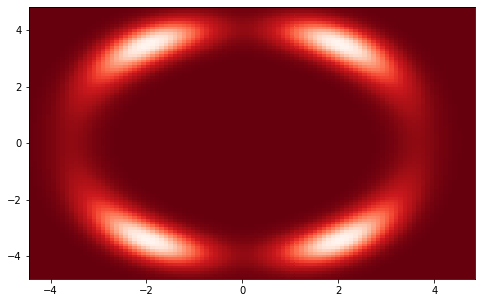

In [51]:
fig,ax=plt.subplots(1,1,figsize = (8,5))
nbins = 100
x, y = samples[:, 0], samples[:, 1]
xi, yi = numpy.mgrid[x.min()-1.5:x.max()+1.5:nbins*1j, y.min()-1.5:y.max()+1.5:nbins*1j]

zi = np.array([trial1(np.vstack([xi.flatten(), yi.flatten()])[:,i]) for i in range(nbins**2)])
ax.pcolormesh(xi, yi, zi.reshape(xi.shape))
ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)
plt.show()

In [21]:
m = lambda x: -1 + np.log(1 + np.exp(x))
h = lambda x: np.tanh(x)
h_prime = lambda x: 1 - np.tanh(x)**2


def gradient_create(target, eps, dim_z, num_samples, K):

    def unpack_params(params):
        W = params[:K*dim_z].reshape(K,dim_z)
        U = params[K*dim_z:2*K*dim_z].reshape(K,dim_z)
        B = params[-K:]
        return W,U,B

    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        W,U,B = unpack_params(params)
        z0 = np.random.multivariate_normal(np.zeros(dim_z), np.eye(dim_z),
                num_samples)
        z_prev = z0
        sum_log_det_jacob = 0.
        for k in range(K):
            w, u, b = W[k], U[k], B[k]
            u_hat = (m(np.dot(w,u)) - np.dot(w,u)) * (w / np.linalg.norm(w)) + u
            affine = np.outer(h_prime(np.matmul(z_prev, w) + b), w)
            sum_log_det_jacob += np.log(eps + np.abs(1 + np.matmul(affine, u)))
            z_prev = z_prev + np.outer(h(np.matmul(z_prev, w) + b), u_hat)
        z_K = z_prev
        log_q_K = -0.5 * np.sum(np.log(2*np.pi) + z0**2, 1) - sum_log_det_jacob
        log_p = np.log(eps + target(z_K))
        return np.mean(log_q_K - log_p)

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

In [22]:
def optimise(func, num_samples, num_iter, lr, K=16, dim_z=2):

    objectives = []
    objective, gradient, unpack_params = gradient_create(func, 1e-7, dim_z, num_samples, K)
    init_W = 1*np.ones((K, dim_z))
    init_U = 1*np.ones((K, dim_z))
    init_b = 1*np.ones((K))
    init_params = np.concatenate((init_W.flatten(), init_U.flatten(), init_b.flatten()))
    
    def callback(params, t, g):
        if t%100 == 0:
            print("Iteration {}; Gradient mag: {}; Objective: {}".format(t,
                np.linalg.norm(gradient(params, t)), objective(params, t)))
            objectives.append(objective(params, t))
        if t%5000 == 0:
            W, U, B = unpack_params(params)
            z0 = np.random.randn(num_samples, dim_z)
            z_prev = z0
            for k in range(K):
                w, u, b = W[k], U[k], B[k]
                u_hat = (m(np.dot(w,u)) - np.dot(w,u)) * (w / np.linalg.norm(w)) + u
                z_prev = z_prev + np.outer(h(np.matmul(z_prev, w) + b), u_hat)
            z_K = z_prev
            plt.figure(figsize=(5,4))
            plt.scatter(z_K[:,0], z_K[:,1])
            plt.show()

    variational_params = adam(gradient, init_params, callback, num_iter, lr)
    
    return variational_params

def visualise(func, variational_params, K=16, dim_z=2, xlimits=[-4,4], ylimits=[-4,4]):
    W, U, B = unpack_params(variational_params)
    z0 = np.random.randn(1000, dim_z)
    z_prev = z0
    for k in range(K):
        w, u, b = W[k], U[k], B[k]
        u_hat = (m(np.dot(w,u)) - np.dot(w,u)) * (w / np.linalg.norm(w)) + u
        z_prev = z_prev + np.outer(h(np.matmul(z_prev, w) + b), u_hat)
    z_K = z_prev
              
    fig, ax = plt.subplots(1,2, figsize=(16,8))
    ax[0].plot(objectives)
              
    nbins = 100
    x, y = z0[:, 0], z0[:, 1]
    xi, yi = numpy.mgrid[-4:4:nbins*1j, -4:4:nbins*1j]
    zi = np.array([func(np.vstack([xi.flatten(), yi.flatten()])[:,i].reshape(-1,2)) for i in range(nbins**2)])
    ax[1].pcolormesh(xi, yi, zi.reshape(xi.shape))
    ax[1].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)
    ax[1].scatter(z_K[:,0], z_K[:,1], alpha=0.2)
    ax[1].set_xlim(xlimits)
    ax[1].set_ylim(ylimits)
    plt.show()

Iteration 0; Gradient mag: 3.610304469398791; Objective: 11.889379782547492


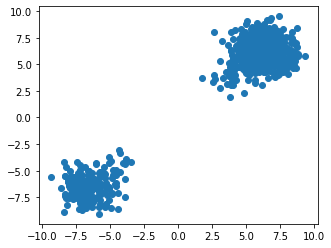

Iteration 100; Gradient mag: 5.722590781510087; Objective: 11.862476587367087
Iteration 200; Gradient mag: 1.3334954176764031; Objective: 11.874216000347362
Iteration 300; Gradient mag: 4.430461974414708; Objective: 11.851651086503427
Iteration 400; Gradient mag: 1.8088085080301655; Objective: 11.876389804706276
Iteration 500; Gradient mag: 4.999415723883317; Objective: 11.856304058252327
Iteration 600; Gradient mag: 1.287032459028523; Objective: 11.603500916378703
Iteration 700; Gradient mag: 5.405292614734293; Objective: 11.59452922869874
Iteration 800; Gradient mag: 5.5669832122162; Objective: 11.600581673289842
Iteration 900; Gradient mag: 3.451462617763777; Objective: 11.651496186232032
Iteration 1000; Gradient mag: 1.347692025731982; Objective: 11.492070736608065
Iteration 1100; Gradient mag: 2.280561618263127; Objective: 11.227286363042968
Iteration 1200; Gradient mag: 2.692013660404631; Objective: 11.192415169936298
Iteration 1300; Gradient mag: 5.082184989971961; Objective: 10

KeyboardInterrupt: 

In [23]:
variational_params = optimise(p1, 1000, 50000, 1e-4, K=16)

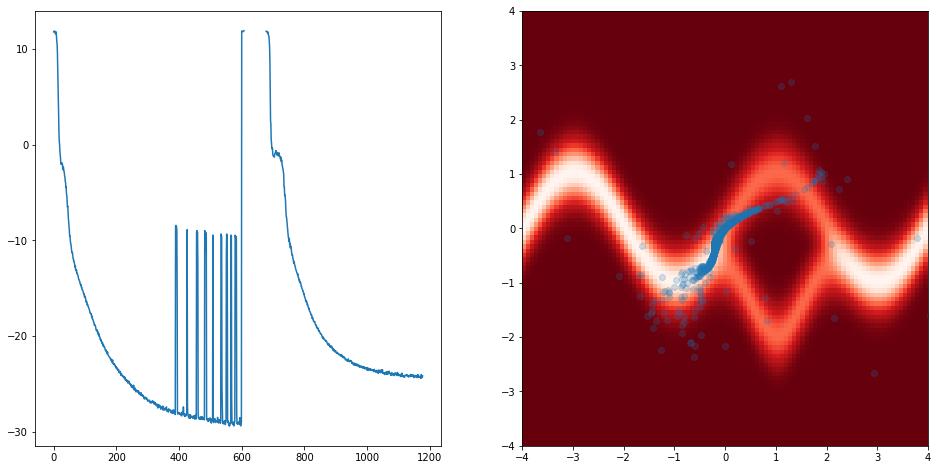

In [74]:
visualise(p1, variational_params)

1. Initialise at a mode --> collapses, eg univariate GMM or bivariate p1 bean.
2. Collapses when high K is used.

#### References
1. Turner, R. E. and Sahani, M. Two problems with variational expectation maximisation for time-series models. In Barber, D., Cemgil, T., and Chiappa, S. (eds.), <em>Bayesian Time series models</em>, chapter 5, pp. 109–130. Cambridge University Press, 2011.

2. Shukla, S., Shimazaki, H., & Ganguly, U. Structured Mean-field Variational Inference and Learning in Winner-take-all Spiking Neural Networks, 2019.

3. Jordan, M. I., Ghahramani, Z., Jaakkola, T. S., and Saul, L. K. An introduction to variational methods for graphical models. <em>Machine learning</em>, 37(2):183–233, 1999.

4. Tabak, E. G. and Turner, C. V. A family of nonparametric density estimation algorithms. <em>Communications on Pure and Applied Mathematics</em>, 66(2):145–164, 2013.

5. Blitzstein, J. K., & Hwang, J. Introduction to Probability (1st ed.). <em>Chapman and Hall</em>, pp. 156, 2014.

6. Pan, W. Lecture 19: Kalman Filters. <em>Harvard Applied Math 207</em>, Fall 2019.